# Random Walks on different networks

## Approach

- Take lattice from graph library and implement MC algorithm 
    - Check for correct behaviour, e.g. diffsuion, end-to-end-distance, every node visited, … 
- Test on other graphs, introduce chaos 
    - Start with lattice and take away nodes 
    - Introduce long range connections to 2d-lattice

#### Random walk 
- standard Random walk 
    - Move to any adjacent node with equal probability 
- Lazy random walk 
    - Prob ½ to stay, prob ½ to move (equally distributed over adjacent nodes)
- IDEA: Both could be combined in one function using lazy=True/False argument

#### Problems
- Measure for distance in a graph with additional edges? 
    -> If we stick with a lattice, we can define our own underlying distance function d(u,v) 
- Walk only to right and distance gets smaller again
- Kleinberg model: Z=const. for periodic lattice, but for non-periodic boundaries?

#### Code optimization

- Parallel Processing (https://www.machinelearningplus.com/python/parallel-processing-python/), but use ```multiprocess``` (install using ```pipenv install multiprocess``` (not ```multiprocessing```)

## Code

In [2]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

from ipywidgets import interact, fixed
from tqdm.notebook import trange, tqdm
%matplotlib inline
import matplotlib.pyplot as plt

import typing
from time import time

np.random.seed(42)

### Lattice graph in networkx

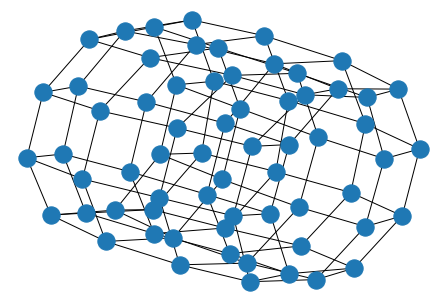

In [3]:
# 2d lattice graph, periodic
L = 8
G = nx.grid_2d_graph(L,L, periodic=True)

# plot
nx.draw(G)

In [4]:
# all nodes have degree 4
nx.degree_histogram(G)

[0, 0, 0, 0, 64]

In [5]:
'''
    Lattice sites are enumerated (row, column) starting on
    upper left with (0,0) ending on lower right with (7,7).
'''
# example: neighbours of node (0,0) and (1,1)
print(list(nx.neighbors(G, (0,0))),'\t', list(nx.neighbors(G, (1,1))))

[(1, 0), (0, 1), (7, 0), (0, 7)] 	 [(0, 1), (2, 1), (1, 0), (1, 2)]


### Starting with random walks

#### Distance functions

In [26]:
# import functions from distances.py file
from distances import dist_1d, dist_2d_lattice

#### Checking our 2d lattice distance and nx.shortest_path_length() algorithm for similar results

In [20]:
u = (0,0)
v = (4,4)
# compare measures

print('Distance between nodes u={}, v={} on 2d lattice graph G with side length L={}'.format(u, v, L),
      '\n\nUsing dist_2d_lattice():', dist_2d_lattice(u,v,L),
      '\nUsing nx.shortest_path_length() on G:', nx.shortest_path_length(G, source=u, target=v))

Distance between nodes u=(0, 0), v=(4, 4) on 2d lattice graph G with side length L=8 

Using dist_2d_lattice(): 8 
Using nx.shortest_path_length() on G: 8


#### Random walk functions

In [22]:
# import function from random_walk.py file
from random_walks import simple_2d_random_walk, lazy_2d_random_walk

#### Draw simple random walk

In [26]:
def plot_walk(G, L, total_path, steps=-1, figure_size=(5,5)):
    # take only specified steps of path (-1 -> complete path)
    path = total_path[:steps]
    # color map
    color_map=[]
    for node in G:
        if node == path[0][0]:
            color_map.append('red') #INITIAL POINT RED
        elif node == path[-1][1]: 
            color_map.append('blue') #END POINT BLUE
        else:
            color_map.append('lightgreen')

    # FIGURE
    plt.figure(figsize=figure_size)
    # make graph R to display the path
    R = nx.grid_2d_graph(L,L,periodic=True)
    R.remove_edges_from(list(R.edges))
    R.add_edges_from(path)
    pos = {(x,y):(y,-x) for x,y in G.nodes()}
    
    # draw underlying network
    nx.draw(G, pos=pos, node_color='lightgreen', edge_color='lightgray',
        with_labels=False, node_size=100, width=3)
    # draw path using R
    nx.draw(R, pos=pos, node_color=color_map, with_labels=False,
        node_size=100, edge_color='red', width=2)
    plt.show()

In [27]:
# T steps of random walk
# always same starting point (0,0)
L=10 # lattice side length
T=100 # steps
G = nx.grid_2d_graph(L, L, periodic=True)
list(G.neighbors((0,0)))

[(1, 0), (0, 1), (9, 0), (0, 9)]

In [28]:
path = simple_2d_random_walk(G, L, T, use_random_starting_node=False)

# plot interactive walk
interact(plot_walk, G=fixed(G), L=fixed(L), total_path=fixed(path), steps=(1, len(path)), figure_size=fixed((5,5)))

interactive(children=(IntSlider(value=1, description='steps', min=1), Output()), _dom_classes=('widget-interac…

<function __main__.plot_walk(G, L, total_path, steps=-1, figure_size=(5, 5))>

#### 2-d Kleinberg model

In [29]:
def Kleinberg_2d(L,r):
    G = nx.grid_2d_graph(L,L, periodic=True)
    Z=0
    for y in G:
        if y!=(0,0):
            Z=Z+dist_2d_lattice((0,0),y,L)**(-r)
    for x in G:
        for y in G:
            if x>y: #to avoid self loop and also double count on the edges
                if np.random.uniform(0, 1)<(dist_2d_lattice(x,y,L)**(-r)/Z):
                    G.add_edge(x,y) 
    return G

### Probabilty distribution of end points of a random walk

In [30]:
# Test concatenation of two paths (containing only single nodes the walker
# moved to, not the complete edges as tuples)
path1 = simple_2d_random_walk(G, L, T, use_random_starting_node=False)
path2 = simple_2d_random_walk(G, L, T, use_random_starting_node=False)
path1_nodes = np.array(path1)[np.newaxis,:,1]
path2_nodes = np.array(path2)[np.newaxis,:,1]

print("Shape of concatenatenation of two random walks (path1 and path2): ",
      np.concatenate((path1_nodes, path2_nodes)).shape, "\n")

Shape of concatenatenation of two random walks (path1 and path2):  (2, 100, 2) 



In [31]:
# Make graph
L = 10
G = nx.grid_2d_graph(L, L, periodic=True)

# Random walk parameters
max_steps = 100
max_walks = int(1e3)

# create array containing multiple random walks (dim = (max_walks, max_steps))
# paths[0] = path0, paths[1] = path1, ... 
# paths[:,i] = nodes of all walks after i-1 steps
paths = np.array([np.array(simple_2d_random_walk(G, L, max_steps, use_random_starting_node=False))[:,1] for _ in range(max_walks)])

In [32]:
def plot_node_probability_from(random_walk_paths, after_num_steps):
    # convert node (row, column) to corresponding integer in enumeration row * L + column
    nodes_after_num_steps_converted = random_walk_paths[:,after_num_steps,0]*L + random_walk_paths[:,after_num_steps,1]
    prob, bins = np.histogram(a=nodes_after_num_steps_converted, bins=np.arange(0,L*L+1), density=True)
    # plot
    plt.figure(), plt.plot(bins[:-1], prob), plt.ylim(-0.001,0.12), plt.show()
    
    
#plot_node_probability_from(paths, after_num_steps=10)
interact(plot_node_probability_from, random_walk_paths=fixed(paths), after_num_steps=(1, max_steps-1))

interactive(children=(IntSlider(value=50, description='after_num_steps', max=99, min=1), Output()), _dom_class…

<function __main__.plot_node_probability_from(random_walk_paths, after_num_steps)>

#### Functions for analysis (still a bit messy, I'll clean up later)

In [33]:
def get_some_paths(G, L, T, M=1000, use_random_starting_node=False, random_walk_function=simple_2d_random_walk):
    # walks
    max_steps = T
    max_walks = M

    # list of random walks (dim = (max_walks, max_steps))
    paths = [np.array(random_walk_function(G, L, max_steps, use_random_starting_node=use_random_starting_node))[:,1] for _ in range(max_walks)]


def get_L1_norm_over_step_count(G, L, max_steps=int(1e2), max_walks=int(1e3), use_random_starting_node=False, random_walk_function=simple_2d_random_walk):
    # walk
    paths = np.array([np.array(random_walk_function(G, L, max_steps, use_random_starting_node=use_random_starting_node))[:,1] for _ in range(max_walks)])
    # compute L1 norm for every random walk step
    norm_vector=[]
    for num_steps in range(max_steps):
        prob, _ = np.histogram(a=paths[:,num_steps,0]*L + paths[:,num_steps,1], bins=np.arange(0,L*L+1), density=True)
        # L1 norm using node distribution from random walks and stationary distriubtion
        # pi_v = d_v/(2*E), with d_v the degree of vertex/node v. For the periodic
        # lattice d_v=4 and hence pi_v = 1/ #nodes_in_G = 1/L*L
        norm_vector.append(0.5 * np.sum(abs(prob - np.ones(prob.shape[0])/(L*L))))
        
    return np.array(norm_vector)

#### Plot total variance for different max_walks

In [34]:
# set seed to get reproducible results
np.random.seed(42)

# Make graph
L = 20
G = nx.grid_2d_graph(L, L, periodic=True)
max_steps = int(5e2)

norm_vector_list = []
for i in tqdm([1,4,8]):
    tic = time()
    norm_vector = get_L1_norm_over_step_count(G, L, max_steps=max_steps, max_walks=int(i*1e3), use_random_starting_node=False, random_walk_function=lazy_2d_random_walk)
    toc = time()
    time_i = toc-tic
    norm_vector_list.append((i, time_i, norm_vector))

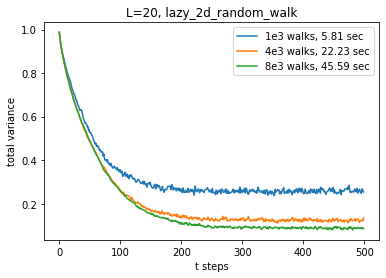

In [35]:
# Plot
fig1, ax1 = plt.subplots()
for i, time_i, norm_vector in norm_vector_list:
    ax1.plot(norm_vector, label="{}e3 walks, {:.2f} sec".format(i, time_i))

ax1.set_title('L={}, lazy_2d_random_walk'.format(L))
ax1.set_xlabel('t steps')
ax1.set_ylabel('total variance')
ax1.legend()
#plt.ylim(-0.01,0.1)
plt.show()

#### Using parallelized functions

Problems:
- Using ```multiprocess``` the ```get_some_paths_parallel()```-function seems to result in a worse distribution than using the one not parallelized
    - Maybe multiple walks start using same RandomState on different CPU's or something like this, leading to similar walks and therefore bad statistics
    - Can be avoided using a different seed for every call of the random walk function... (not so nice, because one needs to pass seeds actively to every other method that makes use of one ot the random walk functions)
- The parallelized algorithm is similar in speed, mostly even behind by a slight bit. 
    - Maybe try parallelized version in a .py script instead of notebook?

In [36]:
from multiprocess import Pool, cpu_count

def simple_2d_random_walk_parallel(G, L, max_steps, start_node=(0,0), use_random_starting_node=False, seed=42):
    np.random.seed(seed)
    if use_random_starting_node:
        current_node = tuple(np.random.randint(0, L, 2))
    else:
        current_node = start_node
        
    path=[]
    # for-loop over max_steps
    for t in range(max_steps):
        # randomly choose from neighbors of current node
        new_node = tuple(list(G.neighbors(current_node))[np.random.randint(0, nx.degree(G, current_node))])
        # append new node to path
        path.append((current_node, new_node))
        current_node = new_node
    return path


def lazy_2d_random_walk_parallel(G, L, max_steps, start_node=(0,0), use_random_starting_node=False, seed=42):
    np.random.seed(seed)
    if use_random_starting_node:
        current_node = tuple(np.random.randint(0, L, 2))
    else:
        current_node = start_node
        
    path=[]
    # for-loop over max_steps
    for t in range(max_steps):
        # stay at current node with p=1/2 or move to a neighboring 
        # node with each p=1/2d_n (d_n degree of current node)
        new_node = current_node if np.random.uniform(0,1) <= 0.5 else tuple(list(G.neighbors(current_node))[np.random.randint(0, nx.degree(G, current_node))])
        # append new node to path
        path.append((current_node, new_node))
        current_node = new_node
    return path


def get_L1_norm_over_step_count_parallel(G, L, max_steps=int(1e2), max_walks=int(1e3), use_random_starting_node=False, random_walk_function=simple_2d_random_walk_parallel):
    # seed list
    seed_list = np.random.permutation(np.arange(0, max_walks)).tolist()

    # list of random walks (dim = (max_walks, max_steps))
    pool = Pool(cpu_count())
    paths = np.array(pool.starmap_async(random_walk_function, [(G, L, max_steps, (0,0), use_random_starting_node, seed) for seed in seed_list]).get())[:,:,1]
    pool.close()

    # compute L1 norm for every random walk step
    norm_vector=[]
    for num_steps in range(max_steps):
        prob, _ = np.histogram(a=paths[:,num_steps,0]*L + paths[:,num_steps,1], bins=np.arange(0,L*L+1), density=True)
        # L1 norm using node distribution from random walks and stationary distriubtion
        # pi_v = d_v/(2*E), with d_v the degree of vertex/node v. For the periodic
        # lattice d_v=4 and hence pi_v = 1/ #nodes_in_G = 1/L*L
        norm_vector.append(0.5 * np.sum(abs(prob - np.ones(prob.shape[0])/(L*L))))
    
    return np.array(norm_vector)

In [37]:
# set seed to get reproducible results
np.random.seed(42)

# Make graph
L = 20
G = nx.grid_2d_graph(L, L, periodic=True)
max_steps = int(5e2)

norm_vector_list_parallel = []
for i in tqdm([1,4,8]):
    tic = time()
    norm_vector = get_L1_norm_over_step_count_parallel(G, L, max_steps=max_steps, max_walks=int(i*1e3), use_random_starting_node=False, random_walk_function=lazy_2d_random_walk_parallel)
    toc = time()
    
    time_i = toc-tic
    norm_vector_list_parallel.append((i, time_i, norm_vector))

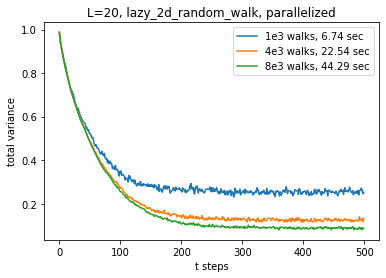

In [38]:
# Plot
fig1, ax1 = plt.subplots()
for i, time_i, norm_vector in norm_vector_list_parallel:
    ax1.plot(norm_vector, label="{}e3 walks, {:.2f} sec".format(i, time_i))

ax1.set_title('L={}, lazy_2d_random_walk, parallelized'.format(L))
ax1.set_xlabel('t steps')
ax1.set_ylabel('total variance')
ax1.legend()
plt.show()

In [ ]:
np.random.seed(42)

# Make graph
max_steps = int(1e3)
#max_walks = int(1e4)

fig1, ax1 = plt.subplots(figsize=(12,8))
for L, max_walks in tqdm([(10, int(1e3)), (20, int(5e3)), (40, int(1e4))]):
    G = nx.grid_2d_graph(L, L, periodic=True)
    tic = time()
    norm_vector = get_L1_norm_over_step_count_parallel(G, L, max_steps=max_steps, max_walks=max_walks, 
                                                       use_random_starting_node=False, 
                                                       random_walk_function=lazy_2d_random_walk_parallel)
    toc = time()
    print(toc-tic)
    ax1.plot(norm_vector, label="L={}, max_walks={}, {:.2f} sec".format(L, max_walks, toc-tic))

ax1.set_title('max_steps={}, lazy_2d_random_walk, parallelized'.format(max_steps))
ax1.set_xlabel('t steps')
ax1.set_ylabel('total variance')
ax1.legend()
plt.show()